# 00+01 — Data Overview & Prep (No Palette)

This all‑in‑one notebook stays **simple** and does **not** use any color palettes.
It uses your repo functions to:
1) **Download** a Kaggle dataset into `../data/raw` (optional, if empty)
2) **Overview** the raw data: class distribution + sample images per class (original colors)
3) **Preprocess**: resize to 16×16 (nearest) and write `labels.csv` (no quantization)
4) **After** view: class distribution + samples from outputs, plus a quick size check


In [1]:
# Make the repo importable (this notebook lives in /notebooks)
import sys, os
REPO_ROOT = os.path.abspath("..")
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)
print("repo root:", REPO_ROOT)


repo root: C:\Users\ruzgh\PycharmProjects\pixelart-ccgen


In [2]:
# --- config ---
RUN_DOWNLOAD = True                         # set False to skip download
DATASET_SLUG = "ebrahimelgazar/pixel-art"   # Kaggle slug (owner/dataset)
RAW_DIR = "../data/raw"
OUT_DIR = "../data/clean_16x16"
TARGET_SIZE = (16, 16)
SAMPLES_PER_CLASS = 6
MAX_CLASSES_TO_SHOW = 6
CLEAN_OUTPUT_FIRST = False

# imports
from pathlib import Path
import random, shutil, csv
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.data.fetch import download_datasets
from src.data.prep import prepare_dataset


In [3]:
# Optional download (only if RAW is empty)
raw = Path(RAW_DIR)
empty = (not raw.exists()) or (len(list(raw.rglob('*'))) == 0)
if RUN_DOWNLOAD and empty:
    print("downloading:", DATASET_SLUG)
    download_datasets(DATASET_SLUG, out_dir=RAW_DIR)   # needs kaggle.json in your user home
else:
    print("skip download (RUN_DOWNLOAD=False or RAW not empty)")


skip download (RUN_DOWNLOAD=False or RAW not empty)


In [4]:
# Helpers
def scan_classes(folder: str | Path):
    folder = Path(folder)
    exts = {".png",".jpg",".jpeg",".bmp",".gif"}
    classes = {}
    if not folder.exists():
        return classes
    subs = [d for d in folder.iterdir() if d.is_dir()]
    if subs:
        for d in sorted(subs):
            files = [p for p in d.rglob("*") if p.suffix.lower() in exts]
            if files: classes[d.name] = files
    else:
        files = [p for p in folder.rglob("*") if p.suffix.lower() in exts]
        if files: classes["pixel"] = files
    return classes

def plot_distribution(classes_dict, title):
    names = list(classes_dict.keys())
    counts = [len(classes_dict[k]) for k in names]
    if not names:
        print("no images found")
        return
    fig, ax = plt.subplots(figsize=(max(6, len(names)*0.8), 3.2))
    ax.bar(names, counts)
    ax.set_title(title)
    ax.set_ylabel("image count")
    ax.set_xticklabels(names, rotation=45, ha="right")
    plt.tight_layout(); plt.show()

def grid_samples(classes_dict, title, per_class=6, max_classes=6):
    names = list(classes_dict.keys())
    if not names:
        print("no classes to show")
        return
    names = names[:max_classes]

    rows = len(names); cols = max(1, per_class)
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.8*rows))
    if rows == 1: axes = np.array([axes])

    for r, cls in enumerate(names):
        files = classes_dict[cls][:]
        random.shuffle(files)
        pick = files[:cols]
        for c, p in enumerate(pick):
            ax = axes[r, c]
            try:
                im = Image.open(p).convert("RGB")  # ORIGINAL colors
                ax.imshow(im)
                ax.axis("off")
                if c == 0: ax.set_title(cls, fontsize=10, loc="left")
            except Exception:
                ax.axis("off")
        for c in range(len(pick), cols):
            axes[r, c].axis("off")
    fig.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout(); plt.show()


RAW classes: ['images'] | total imgs: 89400


C:\Users\ruzgh\AppData\Local\Temp\ipykernel_15024\1964622239.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha="right")


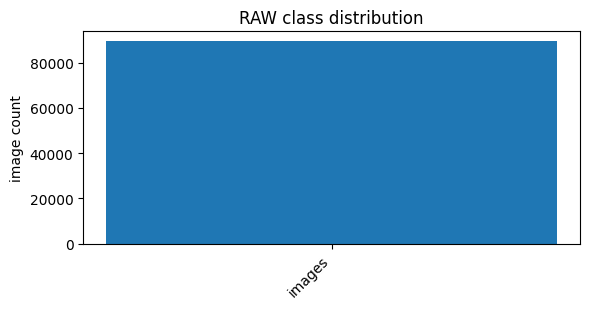

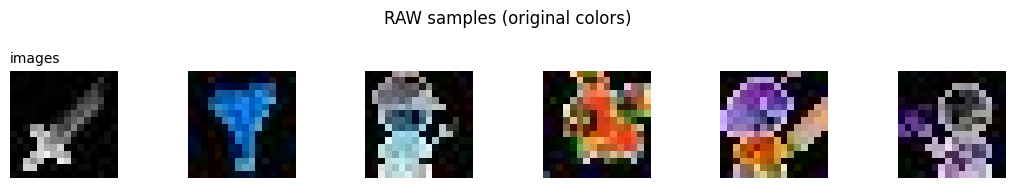

In [5]:
# BEFORE — RAW overview (original colors)
raw_classes = scan_classes(RAW_DIR)
print("RAW classes:", list(raw_classes.keys())[:20], "| total imgs:", sum(len(v) for v in raw_classes.values()))
plot_distribution(raw_classes, "RAW class distribution")
grid_samples(raw_classes, title="RAW samples (original colors)",
             per_class=SAMPLES_PER_CLASS, max_classes=MAX_CLASSES_TO_SHOW)


In [6]:
# RUN PREP (no palette)
out = Path(OUT_DIR)
if CLEAN_OUTPUT_FIRST and out.exists():
    shutil.rmtree(out)

count = prepare_dataset(RAW_DIR, OUT_DIR, size=TARGET_SIZE, palette_json=None)  # NOTE: palette_json=None
print("prepare_dataset wrote images:", count)


done: 89400 images -> ../data/clean_16x16/images
prepare_dataset wrote images: 89400


OUT classes: ['images'] | total imgs: 89400


C:\Users\ruzgh\AppData\Local\Temp\ipykernel_15024\1964622239.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha="right")


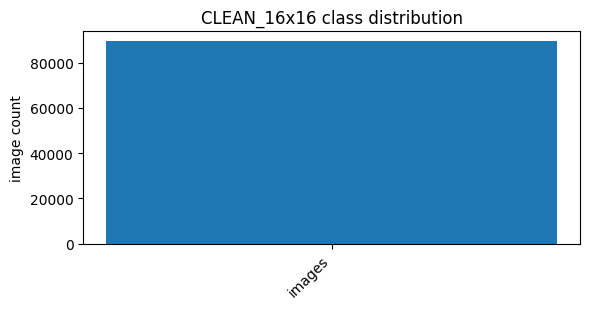

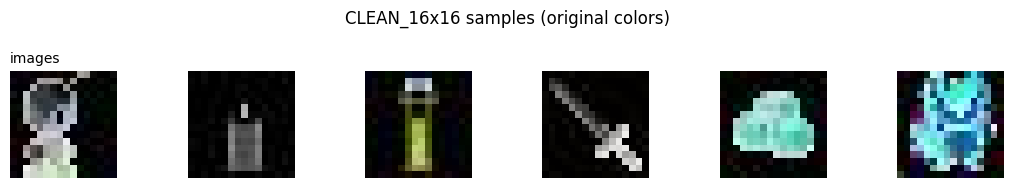

In [7]:
# AFTER — visualize outputs using labels.csv
out = Path(OUT_DIR)
labels_path = out / "labels.csv"
by_class = {}
if labels_path.exists():
    with open(labels_path, encoding="utf-8") as f:
        r = csv.DictReader(f)
        for row in r:
            by_class.setdefault(row["label"], []).append(out/"images"/row["filename"])

print("OUT classes:", list(by_class.keys())[:20], "| total imgs:", sum(len(v) for v in by_class.values()))
plot_distribution(by_class, "CLEAN_16x16 class distribution")
grid_samples(by_class, title="CLEAN_16x16 samples (original colors)",
             per_class=SAMPLES_PER_CLASS, max_classes=MAX_CLASSES_TO_SHOW)


In [8]:
# Sanity: verify some images are 16x16 (no color checks since we keep full RGB)
from itertools import islice
mismatched = []
imgs = list((Path(OUT_DIR)/"images").glob("*.png"))
for p in islice(imgs, 0, 100):
    try:
        with Image.open(p) as im:
            if im.size != TARGET_SIZE:
                mismatched.append(p.name)
    except Exception:
        mismatched.append(p.name)

print("checked:", min(100, len(imgs)), "| size mismatched:", len(mismatched),
      ("examples: " + str(mismatched[:5]) if mismatched else ""))


checked: 100 | size mismatched: 0 
